In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
from scipy.io import arff

# 1. Importation des données

In [25]:
data = arff.loadarff('Dataset/PhishingData.arff')
df = pd.DataFrame(data[0])
df.describe()

,SFH,popUpWidnow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
count,1353,1353,1353,1353,1353,1353,1353,1353,1353,1353
unique,3,3,3,3,3,3,3,2,2,3
top,b'1',b'0',b'1',b'-1',b'-1',b'0',b'0',b'1',b'0',b'-1'
freq,767,639,751,617,610,473,563,825,1198,702


<br><br>

# 2. Analyse des distributions

## 2.1 Distribution de la variable ***Result***

In [21]:
def plot_dist_result():
    fig, ax = plt.subplots(figsize=(7, 7))
    ax = sns.countplot(x='Result', data=df, order=[b'-1', b'0', b'1'])
    ax.set(ylabel='Count')

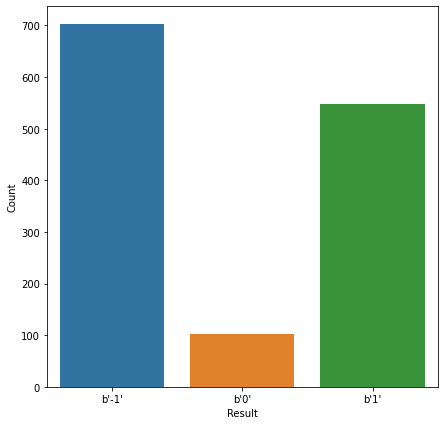

In [22]:
plot_dist_result()

### **Interprétation**
L'on observe dans la distribution de la variable à prédire ***Result*** que la classe Result = '0' est sous représentée (avec une proportion de 7.61%).<br>
Nous devons donc porter une attention particulière à cette classe lors de la construction de notre modèle de classification. Car l'on risquerait d'avoir un modèle ayant une bonne performance globale, mais qui se plante complètement sur cette classe.

## 2.2 Distribution des variables explicatives en fonction de ***Result***

In [17]:
def plot_dist_var_per_result():
    fig, ax = plt.subplots(3, 3, figsize=(15, 15))
    for i, var in enumerate(df.columns[:-1]):
        var_unique_values = df[var].unique()
        var_unique_values.sort()
        sns.countplot(x=var, hue='Result', data=df, ax=ax[int(i/3)][i%3], order=var_unique_values, hue_order=[b'-1', b'0', b'1'])

CPU times: user 329 ms, sys: 4.8 ms, total: 334 ms
Wall time: 360 ms


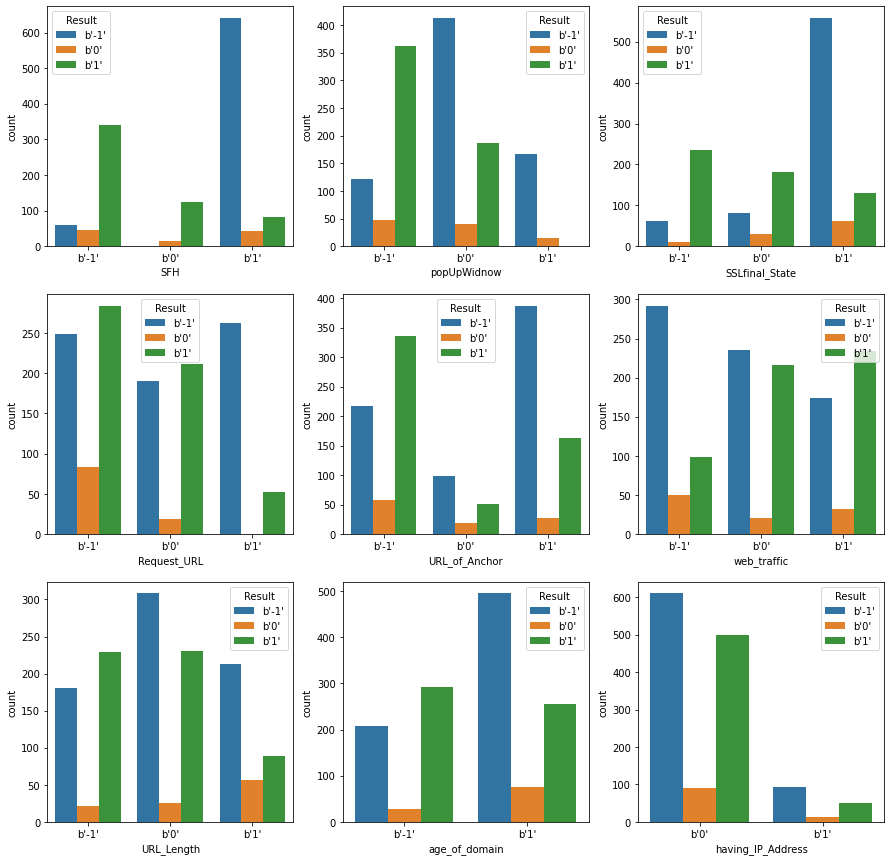

In [18]:
%%time
plot_dist_var_per_result()

### **Interprétation**

L'on observe que contrairement au cas des autres variables, la distribution de la variables ***Result*** reste la même quelque soit la valeur de la variable ***having_IP_Address***. Une étude des corrélations nous permettra d'évaluer s'il s'agit d'une indépendance entre ces deux variables.<br><br><br>

# 3. Analyse des corrélations

## 3.1 Entre variables nominales et ***Result***

Nous avons utilisé dans ce cas la mesure de **Cramer V**, qui est une normalisation de la statistique du **Chi 2** entre 0 et 1.
Une description de cette mesure est disponible [**ici**](https://en.wikipedia.org/wiki/Cramer's_V).

In [26]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    obs = confusion_matrix.sum().sum()
    mini = min(confusion_matrix.shape)-1
    return np.sqrt(chi2/(obs*mini))

In [27]:
def corr_matrix(df):
    corr = pd.DataFrame(index=df.columns, columns=df.columns)
    for i, var1 in enumerate(df.columns):
        for j in np.arange(i, len(df.columns)):
            var2 = df.columns[j]
            if i==j:
                corr[var1][var2] = 1.0
            else:
                corr[var1][var2] = corr[var2][var1] = round(cramers_v(df[var1], df[var2]), 2)
    return corr

In [28]:
def plot_corr_matrix(df):
    fig, ax = plt.subplots(figsize=(12, 10))
    corr = corr_matrix(df)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    heatmap = sns.heatmap(np.array(corr.values, dtype=float), annot=True, xticklabels=df.columns, yticklabels=df.columns)
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

CPU times: user 495 ms, sys: 84.7 ms, total: 579 ms
Wall time: 386 ms


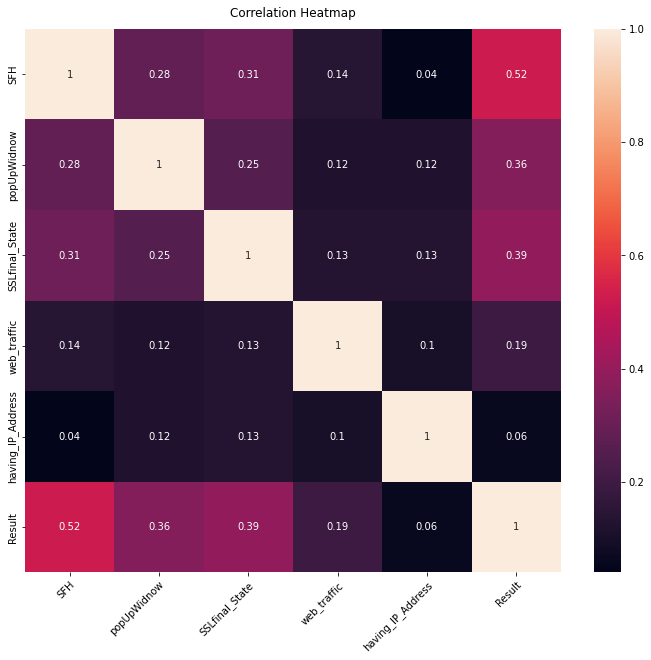

In [30]:
%%time
plot_corr_matrix(df[['SFH', 'popUpWidnow', 'SSLfinal_State', 'web_traffic', 'having_IP_Address', 'Result']])

### **Interprétation**

#### **Entre variables prédictives**
Entre variables prédictives, l'on n'observe pas de coéfficient de corrélation se rapprochant de 1. Nos variables explicatives ne sont donc pas fortement liées.

#### **Entre variables prédictives et variable à prédire**
On remarque que la variable ***having_IP_Address*** a une correlation très faible avec la variable à prédire ***Result***. Un test du Chi 2 nous permettra de refuter ou pas l'hypothèse d'indépendance entre ces deux variables.

In [34]:
chi_square_dist=pd.DataFrame(columns=['Variable', 'Chi2_Score'])
chi_square_p_values=pd.DataFrame(columns=['Variable', 'Chi2_PValue'])
for var in ['SFH', 'popUpWidnow', 'SSLfinal_State', 'web_traffic', 'having_IP_Address']:
    confusion_matrix = pd.crosstab(df[var], df.Result)
    chi2 = ss.chi2_contingency(confusion_matrix)
    chi_square_dist = chi_square_dist.append({'Variable': var, 'Chi2_Score': chi2[0]}, ignore_index = True)
    chi_square_p_values = chi_square_p_values.append({'Variable': var, 'Chi2_PValue': chi2[1]}, ignore_index = True)

<AxesSubplot:xlabel='Variable', ylabel='Chi2_Score'>

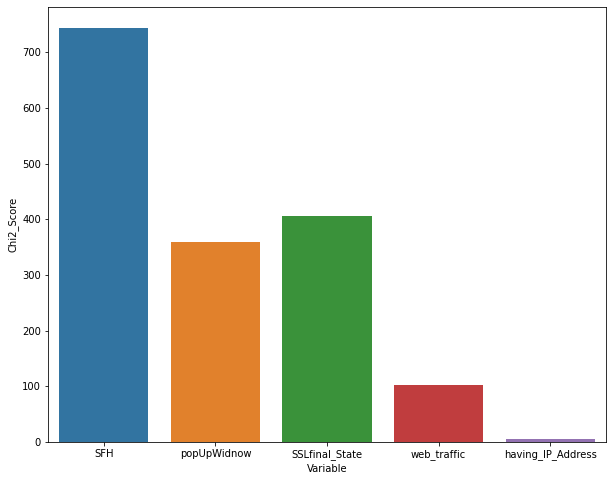

In [38]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x="Variable", y="Chi2_Score", data=chi_square_dist)

<AxesSubplot:xlabel='Variable', ylabel='Chi2_PValue'>

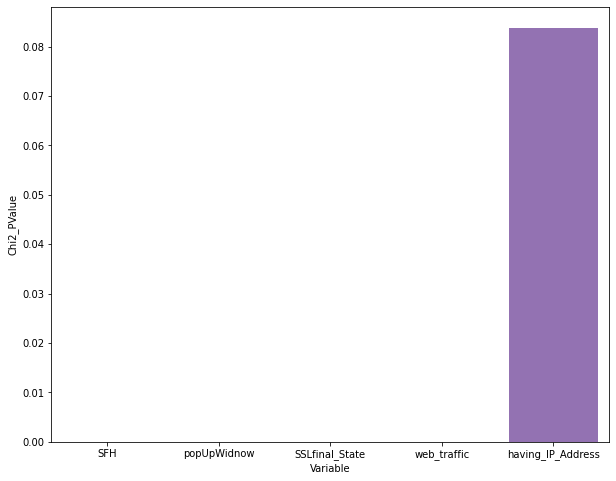

In [39]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x="Variable", y="Chi2_PValue", data=chi_square_p_values)

En éffectuant des tests de Chi 2 sur les hypothèses d'indépendance entre les variables explicatives et la variable à prédire, l'on constate que la statistique de Chi 2 entre la variable ***having_IP_Address*** et la variable ***Result*** vaut 4.95 (Largement plus faible que les autres qui sont de l'ordre de la centaine), pour une P-Value de 0.08 qui est supérieure au seuil habituel de 0.05.<br>
>L'on ne peut donc pas rejéter l'hypothèse selon laquelle ***having_IP_Address*** et ***Result*** sont indépendantes.

Il ne serait donc probablement pas intéressant d'inclure la variable ***having_IP_Address*** dans un modèle de prédiction de ***Result***. L'on pourra vérifier cette assertion en observant l'impact de la variable ***having_IP_Address*** sur les modèles de prédiction de ***Result*** que nous ferons par la suite.

## 3.1 Entre variables ordinales
